In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
DATA_PATH = '/home/var/synthetic_data/dependent_gen/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## LAFTR Training

In [12]:
from synthetic_dataloader import *
shapegender_train = ShapeGenderDataset(train_df)
shapegender_valid = ShapeGenderDataset(val_df)

In [13]:
laftrtrain_loader = DataLoader(shapegender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(shapegender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [14]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [15]:
laftr_adv_criterion = AdvDemographicParityLoss(p=2)
laftr_cls_criterion = nn.BCELoss()

In [16]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.0001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.0001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.0001, betas=(0.9, 0.999))

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [17]:
num_epochs = 20

clsTrain_losses = []
clsTrain_accs = []
trainCombined_losses = []
# clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
# advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [18]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_acc, adv_loss, adv_acc, combined_loss = alfr_train(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
#         clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        trainCombined_losses.append(combined_loss)
#         advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate_dp(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Step -  Encoder: True
Time 2.277 (2.277)
Classifier loss 0.6895 (0.6895)	Adversary loss 0.4982 (0.4982)
Combined loss 1.1877 (1.1877)
Classifier Accuracy 0.5469 (0.5469)	Adversary Accuracy 0.5391 (0.5391)
Batch: [5/40]	Step -  Encoder: False
Time 0.060 (0.572)
Classifier loss 0.6855 (0.6904)	Adversary loss 0.4730 (0.4882)
Combined loss 1.1584 (1.1786)
Classifier Accuracy 0.5703 (0.5143)	Adversary Accuracy 0.5312 (0.5065)
Batch: [10/40]	Step -  Encoder: True
Time 0.050 (0.452)
Classifier loss 0.6841 (0.6879)	Adversary loss 0.4478 (0.4729)
Combined loss 1.1319 (1.1607)
Classifier Accuracy 0.6406 (0.5490)	Adversary Accuracy 0.4922 (0.4957)
Batch: [15/40]	Step -  Encoder: False
Time 0.083 (0.413)
Classifier loss 0.6755 (0.6850)	Adversary loss 0.3477 (0.4442)
Combined loss 1.0232 (1.1292)
Classifier Accuracy 0.6719 (0.5728)	Adversary Accuracy 0.4766 (0.4912)
Batch: [20/40]	Step -  Encoder: True
Time 1.410 (0.451)
Classifier loss 0.6742 (0.6818)	Adversary loss 0.2654 (0.4088)
C

/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/4]	Time 1.701 (1.701)
Classifier loss 0.6383 (0.6383)	Adversary loss 0.0425 (0.0425)
Combined Loss 0.6808 (0.6808)	Classifier Accuracy 0.6562 (0.6562)	Adversary Accuracy 0.5703 (0.5703)
Classifier validation acc: 0.6680 	 Adv validation acc: 0.5200
--------------------
Epoch 0/20	Time 17.295 sec (17.295 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Step -  Encoder: True
Time 1.897 (1.897)
Classifier loss 0.6354 (0.6354)	Adversary loss 0.0696 (0.0696)
Combined loss 0.7050 (0.7050)
Classifier Accuracy 0.6797 (0.6797)	Adversary Accuracy 0.4844 (0.4844)
Batch: [5/40]	Step -  Encoder: False
Time 0.044 (0.589)
Classifier loss 0.6329 (0.6310)	Adversary loss 0.0673 (0.0473)
Combined loss 0.7002 (0.6783)
Classifier Accuracy 0.6875 (0.6849)	Adversary Accuracy 0.5391 (0.5039)
Batch: [10/40]	Step -  Encoder: True
Time 0.320 (0.486)
Classifier loss 0.6091 (0.6244)	Adversary loss 0.0270 (0.0423)
Combined loss 0.6361 (0.6666)
Classifier Accuracy 0.6953 (0.6939)	Adversary Accuracy 0.4531 (0.4922)
Batch: [15/40]	Step -  Encoder: False
Time 0.168 (0.435)
Classifier loss 0.5925 (0.6166)	Adversary loss 0.0253 (0.0365)
Combined loss 0.6178 (0.6531)
Classifier Accuracy 0.7031 (0.7021)	Adversary Accuracy 0.5156 (0.4961)
Batch: [20/40]	Step -  Encoder: True
Time 1.175 (0.466)
Classifier loss 0.6108 (0.6163)	Adversary loss 0.0261 (0.0334)
C

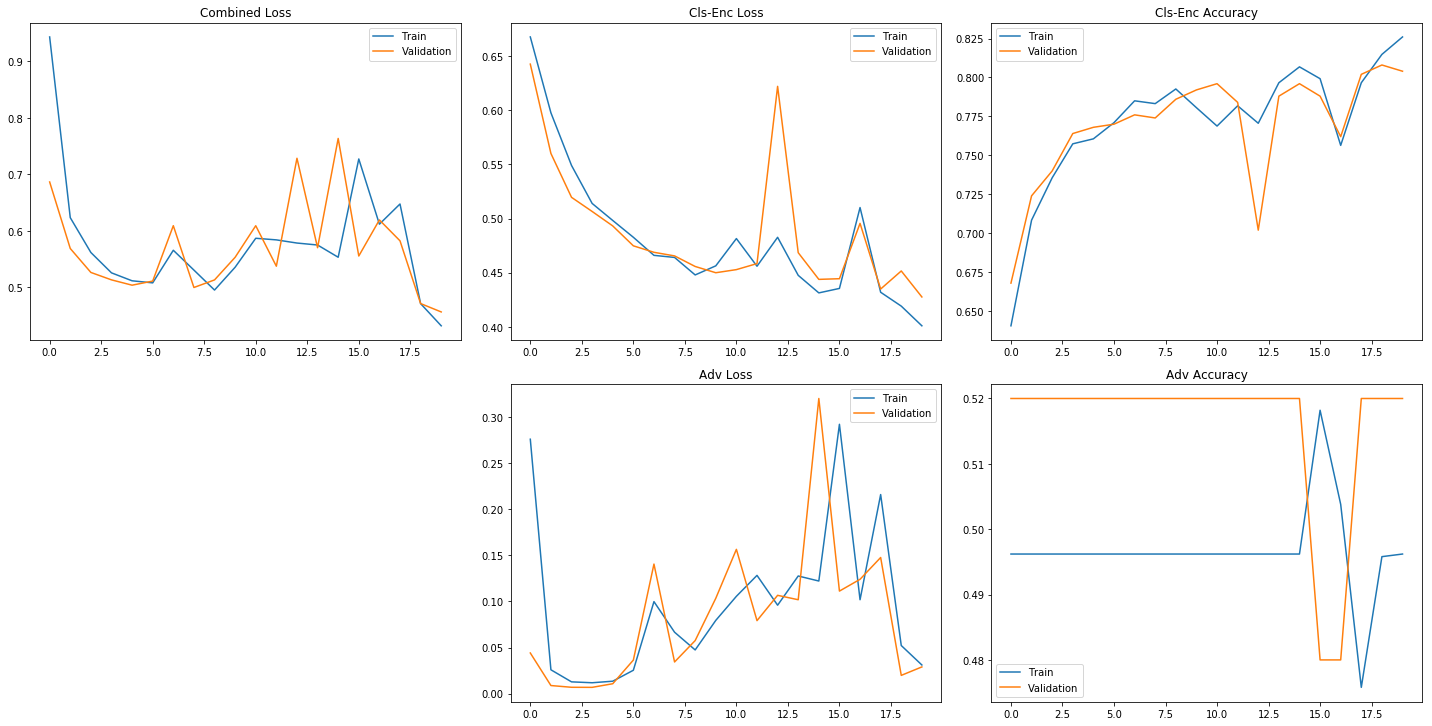

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Loss')
plt.plot(trainCombined_losses, label='Train')
plt.plot(combinedVal_losses, label='Validation')
plt.legend()

plt.subplot(432)
plt.title('Cls-Enc Loss')
plt.plot(clsTrain_losses, label='Train')
plt.plot(clsVal_losses, label='Validation')
plt.legend()

plt.subplot(433)
plt.title('Cls-Enc Accuracy')
plt.plot(clsTrain_accs, label='Train')
plt.plot(clsVal_accs, label='Validation')
plt.legend()

plt.subplot(435)
plt.title('Adv Loss')
plt.plot(advTrain_losses, label='Train')
plt.plot(advVal_losses, label='Validation')
plt.legend()

plt.subplot(436)
plt.title('Adv Accuracy')
plt.plot(advTrain_accs, label='Train')
plt.plot(advVal_accs, label='Validation')
plt.legend()

plt.tight_layout()

In [20]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [21]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [22]:
adversary = ClassNet()

In [23]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [24]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                adversary, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.413 (1.413)	Loss 5.8110 (5.8110)	Accuracy 0.4688 (0.4688)
Batch: [5/40]	Time 0.060 (0.382)	Loss 1.7873 (2.5236)	Accuracy 0.5625 (0.5560)
Batch: [10/40]	Time 0.029 (0.282)	Loss 0.7161 (1.8642)	Accuracy 0.6094 (0.5724)
Batch: [15/40]	Time 0.058 (0.249)	Loss 0.7108 (1.4977)	Accuracy 0.5938 (0.6021)
Batch: [20/40]	Time 0.650 (0.255)	Loss 0.3514 (1.2756)	Accuracy 0.8984 (0.6272)
Batch: [25/40]	Time 0.044 (0.237)	Loss 0.4609 (1.1163)	Accuracy 0.7656 (0.6590)
Batch: [30/40]	Time 0.048 (0.223)	Loss 0.3718 (0.9947)	Accuracy 0.9141 (0.6958)
Batch: [35/40]	Time 0.025 (0.213)	Loss 0.3378 (0.9011)	Accuracy 0.8672 (0.7266)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.939 (0.939)	Loss 0.3192 (0.3192)	Accuracy 0.8672 (0.8672)
Avg validation loss: 0.34668289923667905 	 Accuracy: 0.864
--------------------
Epoch 0/20	Time 9.260 sec (9.260 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.942 (0.942)	Loss 0.3256 (0.3256)	Accuracy 0.8828 (0.8828)
Batch: [5/40]	Time 0.036 (0.288)	Loss 0.3038 (0.3294)	Accuracy 0.9141 (0.8919)
Batch: [10/40]	Time 0.048 (0.234)	Loss 0.3144 (0.3136)	Accuracy 0.8828 (0.8984)
Batch: [15/40]	Time 0.033 (0.212)	Loss 0.3338 (0.3031)	Accuracy 0.8672 (0.9067)
Batch: [20/40]	Time 0.482 (0.223)	Loss 0.2399 (0.2957)	Accuracy 0.9531 (0.9126)
Batch: [25/40]	Time 0.252 (0.217)	Loss 0.2788 (0.2918)	Accuracy 0.9219 (0.9174)
Batch: [30/40]	Time 0.052 (0.207)	Loss 0.2629 (0.2872)	Accuracy 0.9219 (0.9186)
Batch: [35/40]	Time 0.032 (0.199)	Loss 0.2585 (0.2851)	Accuracy 0.9297 (0.9195)
----------
Test: [0/4]	Time 0.927 (0.927)	Loss 0.3599 (0.3599)	Accuracy 0.8203 (0.8203)
Avg validation loss: 0.3431838355064392 	 Accuracy: 0.844
--------------------
Epoch 1/20	Time 8.742 sec (9.001 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.964 (0.964)	Loss 0.2618 (0.2618)	Accuracy 0.8828 (0.8828)
Batch: [5/40]	Time 0.104 (0.289)	Loss 0.2145 

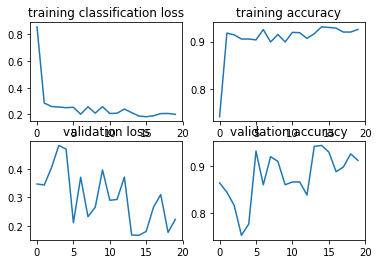

In [25]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)